# SMART Health Cards

This notebook is designed to give an overview of [SMART Health Cards Framework](https://smarthealth.cards/) and how it works.


This notebook is written in JavaScript and uses the [IJavascript kernel](https://github.com/n-riesco/ijavascript) for Jupyter Notebook.

## Walkthrough

The high level outline is as follows:
* FHIR Bundle is created
* FHIR Bundle is minified
* SMART Health Card is created from FHIR Bundle
* SMART Health Card is encoded as a JWS
* Patient Retrieves the SMART Health Cards via:
  * File Download
  * QR Code
  * FHIR API

### The FHIR Bundle

A SMART Health Card is composed of a [W3C Verifiable Credential](https://w3c.github.io/vc-data-model/), [encoded as a JWT](https://w3c.github.io/vc-data-model/#jwt-encoding), with a Credential Subject that contains the FHIR version and a FHIR Bundle (See [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/).

The FHIR Bundle contains the health care information.

Let's assume we have the below FHIR Bundle ([Example 0](https://smarthealth.cards/examples/example-00-a-fhirBundle.json) at the time of writing). This FHIR Bundle could be produced in a number of ways, but for now let's imagine that the patient, John B. Anyperson, has just received his second COVID-19 vaccination shot and the healthcare worker entered his information into their system which produced the below in their system.

In [1]:
const fhirBundle = {
  "resourceType": "Bundle",
  "type": "collection",
  "entry": [
    {
      "fullUrl": "resource:0",
      "resource": {
        "resourceType": "Patient",
        "name": [
          {
            "family": "Anyperson",
            "given": [
              "John",
              "B."
            ]
          }
        ],
        "gender": "male",
        "birthDate": "1951-01-20"
      }
    },
    {
      "fullUrl": "resource:1",
      "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
          "coding": [
            {
              "system": "http://hl7.org/fhir/sid/cvx",
              "code": "207"
            }
          ]
        },
        "patient": {
          "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-01-01",
        "lotNumber": "Lot #0000001",
        "performer": [
          {
            "actor": {
              "display": "ABC General Hospital"
            }
          }
        ]
      }
    },
    {
      "fullUrl": "resource:2",
      "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
          "coding": [
            {
              "system": "http://hl7.org/fhir/sid/cvx",
              "code": "207"
            }
          ]
        },
        "patient": {
          "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-01-29",
        "lotNumber": "Lot #0000007",
        "performer": [
          {
            "actor": {
              "display": "ABC General Hospital"
            }
          }
        ]
      }
    }
  ]
}

A couple things to note in the above JSON. This is a Bundle that contains 3 resources: one for the patient, one for the first vaccination, and another for the second vaccination. This Bundle conforms to the requirements laid out in [SMART Health Cards: Vaccination & Testing Implementation Guide](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/) which defines what resources should be included in the Health Card. Specifically, this is an example of [Vaccine Credential Bundle - Data Minimization](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/StructureDefinition-vaccine-credential-bundle-dm.html). We'll talk about what "Data Minimization" means in a second.

Now let's create the "Expanded Health Card".

### Expanded Health Card

The Expanded Health Card shows what the Health Card looks like before it is minified and serialized using the compact JWS serialization.

[Health Cards are encoded as Compact Serialization JSON Web Signatures (JWS)](https://smarthealth.cards/#health-cards-are-encoded-as-compact-serialization-json-web-signatures-jws) and [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/) cover this in more detail.

Before we get into the details it's important to note that some of the VC properties are mapped to standard JWT fields when using the [JWT encoding](https://w3c.github.io/vc-data-model/#jwt-encoding) (which we are). These include the `iss` and `iat` fields.

Below shows the expanded Health Card for the example:

In [2]:
const expandedHealthCard = {
  "iss": "https://smarthealth.cards/examples/issuer",
  "iat": Date.now() / 1000,
  "vc": {
    "@context": [
      "https://www.w3.org/2018/credentials/v1"
    ],
    "type": [
      "VerifiableCredential",
      "https://smarthealth.cards#health-card",
      "https://smarthealth.cards#immunization",
      "https://smarthealth.cards#covid19"
    ],
    "credentialSubject": {
        "fhirVersion": "4.0.1",
        "fhirBundle": fhirBundle
    }
  }
}

Let's talk about the three root fields:

`iss` - This represents the [Issuer](https://w3c.github.io/vc-data-model/#issuer)
  * Note this property is represented by `iss` according to the [JWT Encoding Rules](https://w3c.github.io/vc-data-model/#jwt-encoding)

`iat` - This represents the [IssuanceDate](https://w3c.github.io/vc-data-model/#issuance-date)
  * Note this property is represented by `iat`. The spec currently, indicates this should be `nbf` so I posted an issue about that to follow up.

`vc` - This represents the VC claim minus all the unmapped fields (`iss` and `iat`)


TODO: Fill out the rest of these properties

### Health Cards are Small

SMART Health Cards can be issued on pieces of paper via QR Codes. This introduces some unique size constraints in order to keep the number and size of QR codes manageable. When using and applying SMART Health Cards, it's important to keep them small.

The SMART Health Card spec requires that [the JWS payload is minified and compressed](https://smarthealth.cards/#health-cards-are-small) in order to reduce payload size.

SMART Health Cards are designed to be be atomic and shared as a whole. Information within the Health Card cannot be removed without affecting the verifiability of the Health Card. This imposes a privacy challenge when too much information is included in a single Health Card.

The "Data Minimization" profiles in the IG are designed to address these size and privacy concerns by ensuring the FHIR profiles only require the minimal set of information to achieve the desired results.

Below the JWS Payload (i.e. the "Expanded Health Card") is compressed according to the spec:

In [3]:
// Remove the optional whitespace
const noWhiteSpaceHealthCard = JSON.stringify(expandedHealthCard)
console.log(noWhiteSpaceHealthCard)

{"iss":"https://smarthealth.cards/examples/issuer","iat":1617110548.812,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Anyperson","given":["John","B."]}],"gender":"male","birthDate":"1951-01-20"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"207"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-01-01","lotNumber":"Lot #0000001","performer":[{"actor":{"display":"ABC General Hospital"}}]}},{"fullUrl":"resource:2","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"h

In [4]:
// Normally we'd remove some of the fhirBundle elements at 
// this step ( e.g. Resource.id, Resource.meta, CodebableConcept.text).
// These are already missing from the original payload, so we'll skip that here

// Compress the payload with DEFLATE, omitting any zlib headers

const compressedPayload = zlib.deflateRawSync(noWhiteSpaceHealthCard)

### Creating the Signed Health Card

Now that we have the compressed payload we can sign it as a JWS. First, let's create the key pair for signing and verifying.

In [5]:
var jose = require('node-jose');

const keystore = jose.JWK.createKeyStore()

let signingKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          signingKey = result;
        });

In [6]:
// Print the entire key store, including the `d` member which contains the private key value
// Remove true to just present the public key
// See: https://tools.ietf.org/id/draft-jones-jose-json-private-and-symmetric-key-00.html#rfc.section.3.1.1
keystore.toJSON(true);

{
  keys: [
    {
      kty: 'EC',
      kid: 's9t6vCszCL9tfKEW8Pie-MZwpv7n9owoPQWNi2B1WyM',
      crv: 'P-256',
      x: 'xxT9GsgcqhQOt2WYzQOAGZN4nEUCfEENlNomrjHIrO4',
      y: 'YndwyMWZICgMjBV64p_sjxaPTmCAGdcIHIhBi7u9QTM',
      d: 'rV-BZn6ofggsrUx3g1LmS5fmALI-l5o5xUOSWc9MgyQ'
    }
  ]
}

With a signing key in hand we can create the JWS:

In [7]:
const fields = { zip: 'DEF' }

let jws;

jose.JWS.createSign({ format: 'compact', fields }, signingKey)
    .update(Buffer.from(compressedPayload))
    .final()
    .then(function(result) {
        jws = result;
        console.log(jws)
});

eyJ6aXAiOiJERUYiLCJhbGciOiJFUzI1NiIsImtpZCI6InM5dDZ2Q3N6Q0w5dGZLRVc4UGllLU1ad3B2N245b3dvUFFXTmkyQjFXeU0ifQ.3VJNj9owEP0raPYKSZzuFsiphUr9UFVV6raXioNxBuLKH5HtBOgq_71jA9tdaeHSWxGXybx5897zPID0HipoQmh9ledecxca5Co0meCu9jnuuW4V-pyAHToYg-QBKvaaTRkr7m5n2YyVY-gFVA_wRlgTcE_9n4-Uu90u273KrNvmZcFmuXBYowmSK5_3DFZjCIcW48QPdHIj-Vrh8hFD-y5quzkWk1hcxUmtOyN_8yCtuQoUtpc1m0dRf2V-69a_UITob9NIRyp95KngNisyRnzx66IztcKIceht5wTeJ1dwapxdgrBKEdtRCS1wB7JOzJ1S350iwHm-KghwLl4g_kp2aJ5Ahms8knAtFfHBW0MY59OOrezRxHg_2SbWiwxWAxncoqnpPSvQPOlbSwrjHQ-Rm83v2KRgk7KAYRi_qI5dV_fxeeQ-8ND5ZD9eU8D4YD0XQhpc2joxCFtLs01G_MEH1Ke7pJdq1DQdUEw697LORb8nApEmoSymMKyGMbSnSJKcDTo0UdvTRAlkhehcakWz91IfKcpkuIi2lA1fOr1O4Xy2YXRTpF9sUaob63RskUwugnVxWy19q3hKfrEcvUeDjqvRB-tbGeiGB1J3Icbyv4yxnF-OcfpvMdJ_GP4A.ggAwM9ijXnnx2c_bL7Vws328zLXPfZb1HDDPXt6LfwxaqFv9mV5AV_t6KVWAiikkwLEUJQ4lGQH-VNgzu1qfNQ


Now that we have the JWS we should check that we can actually verify the signature

In [8]:
jose.JWS.createVerify(signingKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

{
  protected: [ 'zip', 'alg', 'kid' ],
  header: {
    zip: 'DEF',
    alg: 'ES256',
    kid: 's9t6vCszCL9tfKEW8Pie-MZwpv7n9owoPQWNi2B1WyM'
  },
  payload: <Buffer dd 52 4d 8f da 30 10 fd 2b 68 f6 0a 49 9c ee 16 c8 a9 85 4a fd 50 55 55 ea b6 97 8a 83 71 06 e2 ca 1f 91 ed 04 e8 2a ff bd 63 03 db 5d 69 e1 d2 5b 11 ... 430 more bytes>,
  signature: <Buffer 82 00 30 33 d8 a3 5e 79 f1 d9 cf db 2f b5 70 b3 7d bc cc b5 cf 7d 96 f5 1c 30 cf 5e de 8b 7f 0c 5a a8 5b fd 99 5e 40 57 fb 7a 29 55 80 8a 29 24 c0 b1 ... 14 more bytes>,
  key: JWKBaseKeyObject {
    keystore: JWKStore {},
    length: 256,
    kty: 'EC',
    kid: 's9t6vCszCL9tfKEW8Pie-MZwpv7n9owoPQWNi2B1WyM',
    use: '',
    alg: ''
  }
}


Let's also create a fake key and test with that to make sure we aren't getting a false positive

In [9]:
let fakeKey;

keystore.generate("EC", "P-256").
        then(function(result) {
          // {result} is a jose.JWK.Key
          fakeKey = result;
        });

In [10]:
// Note "Error: no key found" is the generic error message for keys that won't decrypt
// See: https://github.com/cisco/node-jose/issues/262
jose.JWS.createVerify(fakeKey)
    .verify(jws).then(function(result) {
    console.log(result)
})

Error: no key found

### QR Code Generation

Now that we have a JWS we can turn that into a QR Code which can be scanned. We won't worry about chunking just yet since the payload is below the 1195 character threshold in this example, but its a simple addition and [this code snippet](https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L146) goes over the process.

In [11]:
// Convert to numeric mode QR

// This code snippet was adapted/taken from https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L173
const numericJWS = jws.split('')
    .map((c) => c.charCodeAt(0) - 45)
    .flatMap((c) => [Math.floor(c / 10), c % 10]) //Need to maintain leading zeros
    .join('')

console.log('shc:/' + numericJWS)

shc:/56762909524320603460292437404460312229595326546034602925407728043360287028647167452228092865320855234505360633093603740855264531374154074026636331400452550621053305070853065573402525433964627636612543564003605736010641293361126674243503695235443038457772257060675940691240254141096952436066337521723130270827712134586850100461201271555256273842752643765375081112107735282303276067663664591263565556547554520822660364562272126165727242074100677620273966445800362130735252393762691064086505447641440058254120507437635839542450126507004072120372051006306933736445542564724321446674643830085006232545612228544207113635552728610041695911592523007608687277624262045954754064713476335011762271723666407167540464035537570541000912525040283966531233283776671208306558336070763765777509092877715430285456597108743956290455745267755558692130245571372238047421102934772904380608036074276400305859743163075850626705522908205964701162652071255727214203324408123434695677377527585005385342607475422075655466686

The above shows what the value of the QR code will be, with the leading `byte` segment and the `numeric` segment following

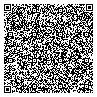

In [12]:
var QRCode = require('qrcode')

const segments = [
    {data: 'shc:/', mode: 'byte'},
    {data: numericJWS, mode: 'numeric'}
]

const qrSVG = QRCode.toString(segments,{type: 'svg', errorCorrectionLevel: 'low' })

$$.svg(qrSVG)